<a href="https://colab.research.google.com/github/Nik8x/Facebook_network_analysis_NetworkX.ipynb/blob/master/Facebook_network_analysis_NetworkX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Facebook Ego Networks dataset](https://snap.stanford.edu/data/egonets-Facebook.html)

[jupyter notebook link](https://app.dominodatalab.com/u/LeJit/FacebookNetwork/view/results/SocialNetwork.html)

[Social network analysis with NetworkX](https://blog.dominodatalab.com/social-network-analysis-with-networkx/)

In an ego network, there is a “central” vertex or the ego vertex which the network revolves around.

Ego networks are important in sociology because they allow researchers to study the structure of an individual’s relationships with respect to his world.

This Facebook combined ego networks datasets contains the aggregated network of ten individuals’ Facebook friends list. In this dataset, the vertices represent individuals on Facebook, and an edge between two users means they are Facebook friends. Each ego-network was created by starting with a Facebook user and then mining all of his Facebook friends. The ego-networks are then aggregated by identifying individuals who appear in multiple ego-networks.

**Exploratory Data Analysis**

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype = int)

In [34]:
#Quick snapshot of the Network
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [0]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_fb)

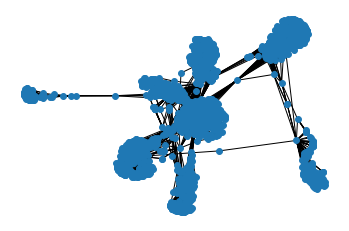

In [36]:
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)

As we can see this is a fairly connected network, and the number of edges in the network is more than 20x the number of nodes, so the network is densely clustered. If you examine the network, you will notice certain hubs of vertices appear. Hubs like these are an important feature of real-world social networks. Dense hubs represent high clustering and are often the result of underlying social mechanisms that are of interest to scientists.

**Parallel Betweenness Centrality**

How do we determine who is the most “important” individual in the network. Well, that depends on the definition of “important”. One way to define “importance” is the individual’s betweenness centrality. The betweenness centrality is a measure of how many shortest paths pass through a particular vertex. The more shortest paths that pass through the vertex, the more central the vertex is to the network.

Because the shortest path between any pair of vertices can be determined independently of any other pair of vertices, we can compute the betweenness centrality of each vertex in the network using a parallelized algorithm.

To do this, we will use the Pool object from the multiprocessing library and the itertools library. 

In [0]:
from multiprocessing import Pool
import itertools

First thing we need to do is partition the vertices of the network into n subsets where n is dependent on the number of processors we have access to. For example, if we use a machine with 32 cores, we partition the Facebook network in 32 chunks with each chunk containing 128 vertices.

Now instead of one processor computing the betweenness for all 4,039 vertices, we can have 32 processors computing the betweenness for each of their 128 vertices in parallel. This drastically reduces the run-time of the algorithm and allows it to scale to larger networks.

In [0]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [0]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [0]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

let’s look at the vertices with the top 10 highest betweenness centrality measures in the network.

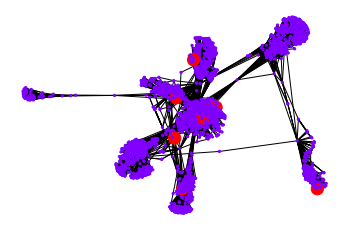

In [42]:
bt = between_parallel(G_fb)
top = 10

max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(G_fb.nodes())
bt_colors = [0]*len(G_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

As we can see, vertices that primarily either sit at the center of a hub or acts a bridge between two hubs have higher betweenness centrality. The bridge vertices have high betweenness because all paths connecting the hubs pass through them, and the hub center vertices have high betweenness because all intra-hub paths pass through them.

**Community Detection**

Community Detection
For those of you who use Facebook, your Facebook friends probably come from different aspects of your life: Some are your friends from college, others are your co-workers, and maybe some old friends from your hometown.

Because your friends can be broken down into different groups like this, you may wonder if we could identify these different communities in your social network. The answer is yes! Using community detection algorithms, we can break down a social network into different potentially overlapping communities.

The criteria for finding good communities is similar to that for finding good clusters. We want to maximize intra-community edges while minimizing inter-community edges. Formally, the algorithm tries to maximize the modularity of network, or the fraction of edges that fall within the community minus the expected fraction of edges if the edges were distributed by random. Good communities should have a high number of intra-community edges, so by maximizing the modularity, we detect dense communities that have a high fraction of intra-community edges.

In [0]:
import community

In [0]:
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]

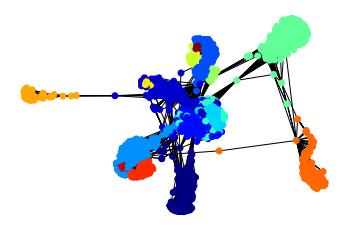

In [47]:
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

As you can see, the communities closely align with the vertex hubs. Because this dataset was compiled by aggregating the ego network of ten individuals, the different communities most likely reflect the different ego networks.